In [4]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.auto import tqdm
from torch import nn
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torchmetrics
import torchinfo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
root_dir = Path('data_classification')

dataset = ImageFolder(root=root_dir, transform=None)

print(f'Number of classes: {len(dataset)}')

Number of classes: 1200


In [22]:
dataset.class_to_idx
dataset.classes

['oil', 'scratch', 'stain']

In [7]:


transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])


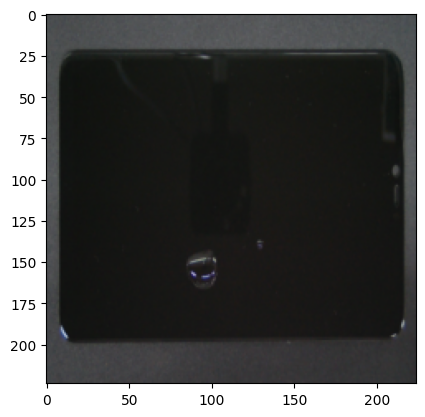

In [8]:
dataset = ImageFolder(root=root_dir, transform=transform)

x,y = dataset[0]
plt.imshow(x.permute(1,2,0))

# Train test split

In [9]:


train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])

print(len(train_dataset))
print(len(test_dataset))


960
240


# Data loader for mini batch training

In [10]:


train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=16, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=16, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data


In [11]:
idx=0
for x,y in train_dataloader:
    print(x.shape, y.shape)
    idx+=1
    print(idx)
    


torch.Size([16, 3, 224, 224]) torch.Size([16])
1
torch.Size([16, 3, 224, 224]) torch.Size([16])
2
torch.Size([16, 3, 224, 224]) torch.Size([16])
3
torch.Size([16, 3, 224, 224]) torch.Size([16])
4
torch.Size([16, 3, 224, 224]) torch.Size([16])
5
torch.Size([16, 3, 224, 224]) torch.Size([16])
6
torch.Size([16, 3, 224, 224]) torch.Size([16])
7
torch.Size([16, 3, 224, 224]) torch.Size([16])
8
torch.Size([16, 3, 224, 224]) torch.Size([16])
9
torch.Size([16, 3, 224, 224]) torch.Size([16])
10
torch.Size([16, 3, 224, 224]) torch.Size([16])
11
torch.Size([16, 3, 224, 224]) torch.Size([16])
12
torch.Size([16, 3, 224, 224]) torch.Size([16])
13
torch.Size([16, 3, 224, 224]) torch.Size([16])
14
torch.Size([16, 3, 224, 224]) torch.Size([16])
15
torch.Size([16, 3, 224, 224]) torch.Size([16])
16
torch.Size([16, 3, 224, 224]) torch.Size([16])
17
torch.Size([16, 3, 224, 224]) torch.Size([16])
18
torch.Size([16, 3, 224, 224]) torch.Size([16])
19
torch.Size([16, 3, 224, 224]) torch.Size([16])
20
torch.Siz

# Create the deep learning model

In [13]:

cnn_model = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights)

for param in cnn_model.parameters():
    param.requires_grad = False

cnn_model.fc = nn.Linear(2048,out_features=len(dataset.classes))

In [14]:
torchinfo.summary(cnn_model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [15]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=0.001)


accuracy_estimator = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(dataset.classes)).to(device)

In [16]:

cnn_model.to(device)
# Set the number of epochs (we'll keep this small for faster training times)
epochs = 10

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        cnn_model.train() 
        # 1. Forward pass
        y_pred = cnn_model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 20 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    cnn_model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X,y = X.to(device),y.to(device)
            # 1. Forward pass
            test_pred = cnn_model(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_estimator(test_pred.softmax(dim=-1), y)
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 1.00699 | Test loss: 0.92494, Test acc: 0.71%

Epoch: 1
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 0.85278 | Test loss: 0.78781, Test acc: 0.82%

Epoch: 2
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 0.75344 | Test loss: 0.68830, Test acc: 0.88%

Epoch: 3
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 0.67668 | Test loss: 0.61843, Test acc: 0.91%

Epoch: 4
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 0.61496 | Test loss: 0.56511, Test acc: 0.90%

Epoch: 5
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/960 samples

Train loss: 0.56660 | Test loss: 0.51908, Test acc: 0.91%

Epoch: 6
-------
Looked at 0/960 samples
Looked at 320/960 samples
Looked at 640/9

In [17]:
torch.save(cnn_model.state_dict(), 'cnn_model_weights.pth')

In [18]:
cnn_model = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights)

for param in cnn_model.parameters():
    param.requires_grad = False

cnn_model.fc = nn.Linear(2048,out_features=len(dataset.classes))

cnn_model.load_state_dict(torch.load('cnn_model_weights.pth'))
cnn_model.to(device)
cnn_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
for x,y in test_dataloader:
    x=x.to(device)
    y=y.to(device)
    break

with torch.inference_mode():
    y_pred = cnn_model(x)

In [24]:
predicted_classes = [dataset.classes[yy] for yy in y_pred.argmax(dim=-1).cpu()]
true_classes = [dataset.classes[yy] for yy in y.cpu()]
confidence = [torch.nn.functional.softmax(c).max() for c in y_pred.cpu()]

C:\Users\Asus\AppData\Local\Temp\ipykernel_8008\3028661620.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence = [torch.nn.functional.softmax(c).max() for c in y_pred.cpu()]


In [25]:
confidence

[tensor(0.8888),
 tensor(0.6548),
 tensor(0.6809),
 tensor(0.7861),
 tensor(0.8586),
 tensor(0.6893),
 tensor(0.6321),
 tensor(0.7720),
 tensor(0.7628),
 tensor(0.5217),
 tensor(0.7961),
 tensor(0.8965),
 tensor(0.5550),
 tensor(0.5979),
 tensor(0.8019),
 tensor(0.3559)]

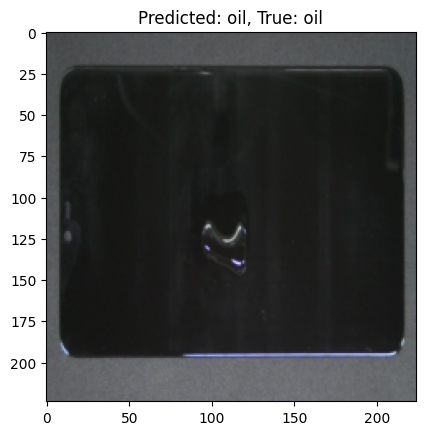

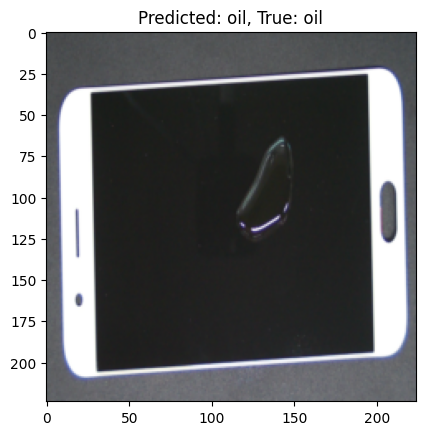

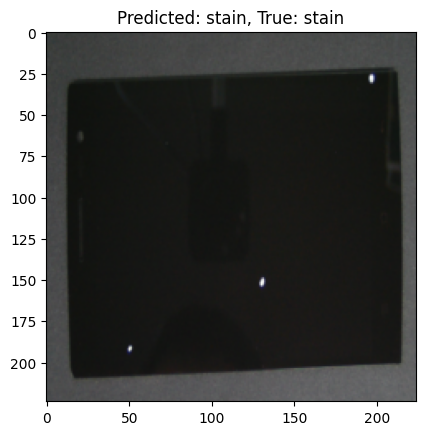

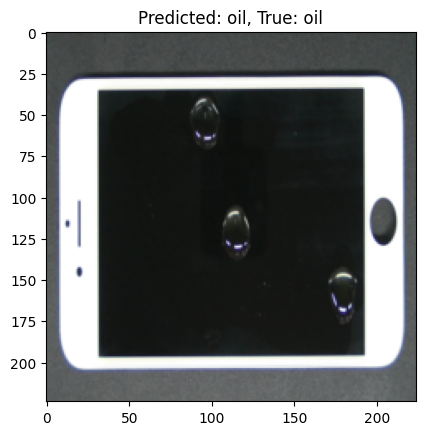

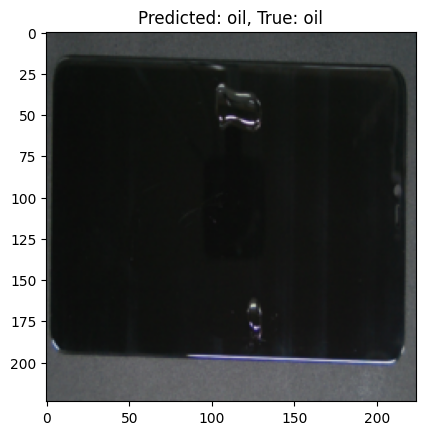

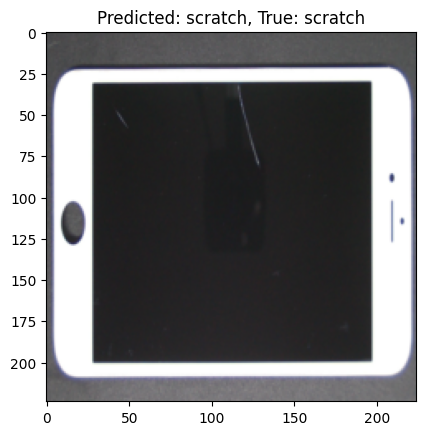

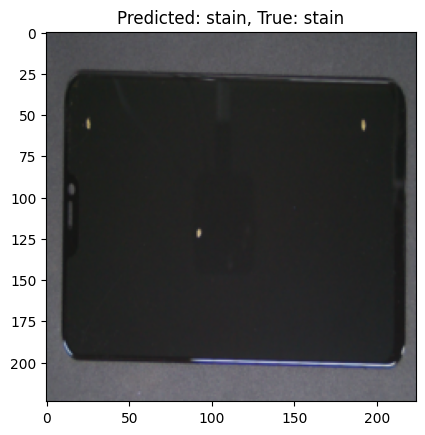

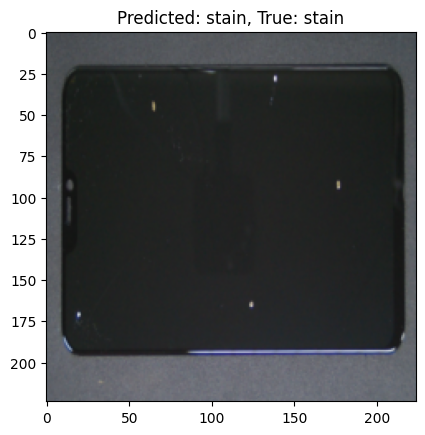

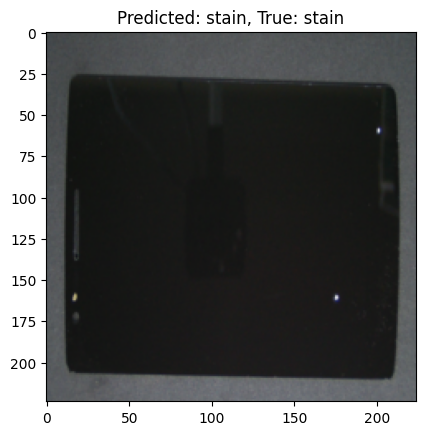

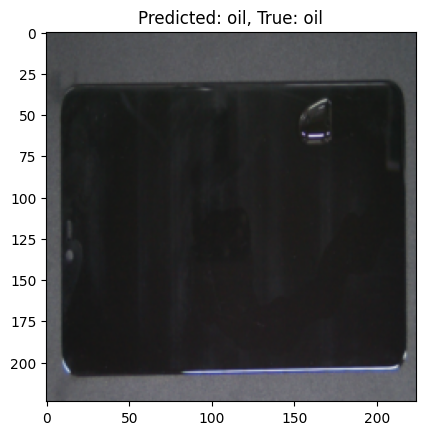

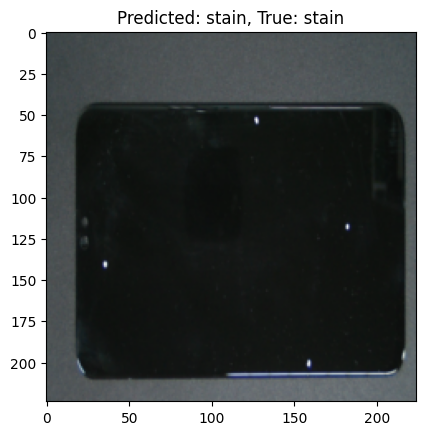

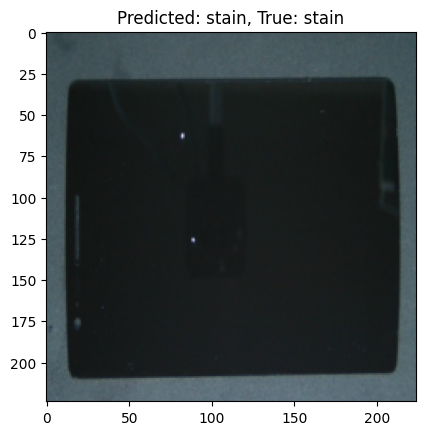

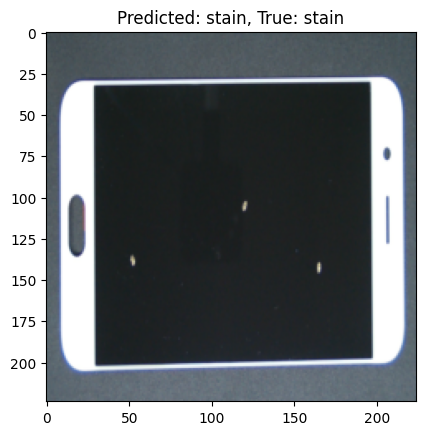

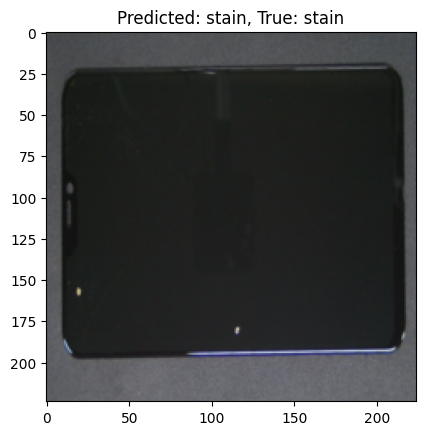

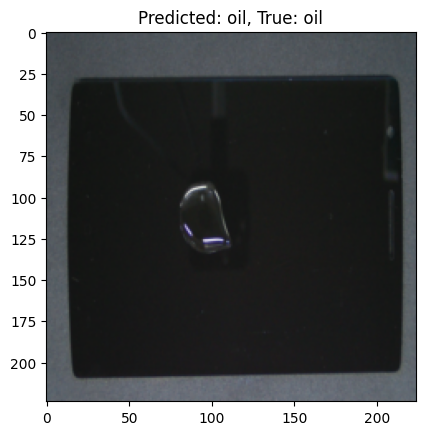

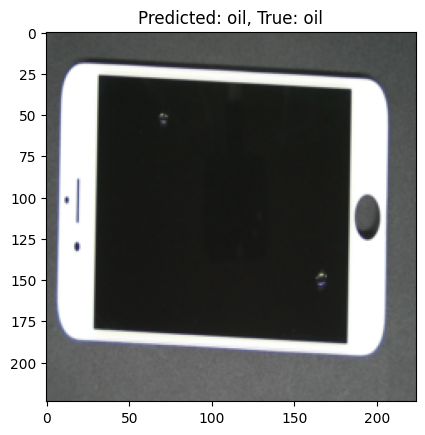

In [21]:
for idx,xx in enumerate(x):
    plt.imshow(xx.permute(1,2,0).cpu())
    plt.title(f'Predicted: {predicted_classes[idx]}, True: {true_classes[idx]}')
    plt.show()

In [112]:
len(train_dataset)

960